In [45]:
import requests
import zipfile
import pandas as pd
import numpy as np
import os
import nibabel
import matplotlib.pyplot as plt
import utils
%matplotlib inline
import tensorflow as tf
from tensorflow.python.framework import ops

from scipy.ndimage import zoom

import pandas as pd
import numpy as np
import os
import zipfile
import shutil
import math

In [46]:
data_dir = "/Users/zack/zack/deep_learning/gcp/"
train_img = np.load(data_dir+"train_img.npy")
train_age = np.load(data_dir+"train_age.npy")
train_sex = np.load(data_dir+"train_sex.npy")
train_label = np.load(data_dir+"train_label.npy")

val_img = np.load(data_dir+"val_img.npy")
val_age = np.load(data_dir+"val_age.npy")
val_sex = np.load(data_dir+"val_sex.npy")
val_label = np.load(data_dir+"val_label.npy")

#one-hot encoder for label
train_label = pd.get_dummies(train_label.squeeze()).values
val_label = pd.get_dummies(val_label.squeeze()).values

In [47]:
#here I use 2 images as sample data
train_img = train_img[:2]
train_age = train_age[:2]
train_sex = train_sex[:2]
train_label = train_label[:2]

print(train_img,train_age.shape,train_sex.shape,train_label)

#get validation data
val_img = val_img[:1]
val_age = val_age[:1]
val_sex = val_sex[:1]
val_label = val_label[:1]

print(val_img,val_age.shape,val_sex.shape,val_label)

['fs_t1/OAS30001_MR_d0129.nii.gz' 'fs_t1/OAS30001_MR_d0757.nii.gz'] (2,) (2,) [[1 0 0 0 0 0]
 [1 0 0 0 0 0]]
['fs_t1/OAS30945_MR_d0155.nii.gz'] (1,) (1,) [[1 0 0 0 0 0]]


In [48]:
#add a new axis to age and sex
train_age = train_age.reshape(-1,1)
train_sex = train_sex.reshape(-11,1)
val_age = val_age.reshape(-1,1)
val_sex = val_sex.reshape(-1,1)

In [49]:
#get trainning data
X_train = np.zeros((1,128,128,128))
data_path = '/Users/zack/zack/deep_learning/gcp/'
for image in train_img:
    X_train = np.append(X_train,zoom(nibabel.load(data_path + image).get_data(),(0.5, 0.5, 0.5))[np.newaxis,:],axis=0)
#get rid of the first zero 
X_train = X_train[1:]
#assign Y_train as train_label
Y_train = train_label
print(X_train.shape,train_label.shape)

(2, 128, 128, 128) (2, 6)


In [50]:
#get the test data
X_test = np.zeros((1,128,128,128))
data_path = '/Users/zack/zack/deep_learning/gcp/'
for image in val_img:
    X_test = np.append(X_test,zoom(nibabel.load(data_path + image).get_data(),(0.5, 0.5, 0.5))[np.newaxis,:],axis=0)
#get rid of the first zero 
X_test = X_test[1:]
#assign Y_test as val_label
Y_test = val_label
print(X_test.shape,Y_test.shape)
X_train /= 255
X_test /= 255
X_train = X_train[:,:,:,:,np.newaxis]
X_test = X_test[:,:,:,:,np.newaxis]

(1, 128, 128, 128) (1, 6)


In [51]:
# train data :X_train, train_age, train_sex,Y_train
# test data : X_test, val_age, val_sex, Y_test
#2d -> 3d 

print(X_train.shape ,Y_train.shape, train_age.shape,train_sex.shape)
print(X_test.shape,Y_test.shape,val_age.shape,val_sex.shape)

(2, 128, 128, 128, 1) (2, 6) (2, 1) (2, 1)
(1, 128, 128, 128, 1) (1, 6) (1, 1) (1, 1)


# Model

In [56]:
def create_placeholders(n_M0, n_H0, n_W0, n_C0, n_y):#create placeholders for X Y AGE SEX
    """
    Arguments:
    n_M0 -- scalar, how many image one second
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
    """
    X = tf.placeholder(tf.float32, shape=(None,n_M0,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32, shape=(None,n_y))
    age = tf.placeholder(tf.float32, shape=(None,1))
    sex = tf.placeholder(tf.float32, shape=(None,1))
    return X, Y, age, sex

def initialize_parameters():

    tf.set_random_seed(1)                              # so that your "random" numbers match ours
    W1 = tf.get_variable('W1',[4,4,4,1,8],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable('W2',[2,2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    parameters = {"W1": W1,
                  "W2": W2}
    return parameters

def forward_propagation(X,age,sex, parameters):
    """
    Implements the forward propagation for the model:
    CONV3D -> RELU -> MAXPOOL -> CONV3D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    

    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv3d(X,W1, strides = [1,1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool3d(A1, ksize = [1,8,8,8,1], strides = [1,8,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv3d(P1,W2,strides = [1,1,1,1,1],padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool3d(A2,ksize = [1,4,4,4,1],strides=[1,4,4,4,1],padding='SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    
    #Add gender and age into p2 layer
    
    age  = tf.layers.Flatten()(age)
    sex = tf.layers.Flatten()(sex)
    P2 = tf.concat([P2,age,sex],1)
    
    # FULLY-CONNECTED without non-linear activation function (not call softmax).
    P2 = tf.layers.dense(inputs=P2, units=100, activation=tf.nn.relu)
    
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, num_outputs = 6,activation_fn=None)

    return Z3
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

def random_mini_batches(X, Y,age,sex, mini_batch_size = 3, seed = 0):
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y,age,sex)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:]
    shuffled_Y = Y[permutation,:]
    shuffled_age = age[permutation,:]
    shuffled_sex = sex[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y,shuffled_age,shuffled_sex). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
      
        mini_batch_X =  shuffled_X[mini_batch_size * k : (k+1) * mini_batch_size,:]
        mini_batch_Y = shuffled_Y[mini_batch_size * k : (k+1) * mini_batch_size,:]
        mini_batch_age = shuffled_age[mini_batch_size * k : (k+1) * mini_batch_size,:]
        mini_batch_sex = shuffled_sex[mini_batch_size * k : (k+1) * mini_batch_size,:]
       
        mini_batch = (mini_batch_X, mini_batch_Y, mini_batch_age,mini_batch_sex)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : ,: ]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : ,:]
        mini_batch_age = shuffled_age[num_complete_minibatches * mini_batch_size : ,: ]
        mini_batch_sex = shuffled_sex[num_complete_minibatches * mini_batch_size : ,: ]

        mini_batch = (mini_batch_X, mini_batch_Y,mini_batch_age,mini_batch_sex)
        mini_batches.append(mini_batch)
    
    return mini_batches

def model(X_train, Y_train, train_age, train_sex,
          X_test, Y_test, val_age, val_sex,
          learning_rate = 0.009, num_epochs = 5, minibatch_size = 1, print_cost = True):
    ops.reset_default_graph()                         
    
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m,n_M0, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = [] 
    
    X, Y, age, sex = create_placeholders(n_M0=n_M0, n_H0=n_H0, n_W0=n_W0, n_C0=n_C0, n_y=n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,age,sex, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            
            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train,train_age,train_sex, minibatch_size, seed)


            for minibatch in minibatches:
                (minibatch_X, minibatch_Y, mini_batch_age,mini_batch_sex) = minibatch
                _ , temp_cost = sess.run(optimizer,feed_dict={X:minibatch_X,Y:minibatch_Y,age:mini_batch_age,sex:mini_batch_sex}),sess.run(cost,feed_dict={X:minibatch_X,Y:minibatch_Y,age:mini_batch_age,sex:mini_batch_sex})
                
                minibatch_cost += temp_cost / num_minibatches
            if print_cost == True and epoch % 1 == 0:
                    print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                    costs.append(minibatch_cost)
                
                
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train, age:train_age, sex:train_sex})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test, age: val_age, sex: val_sex})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)

        return train_accuracy, test_accuracy, parameters
    

Cost after epoch 0: 0.132283
Cost after epoch 1: 0.000000
Cost after epoch 2: 0.000000
Cost after epoch 3: 0.000000
Cost after epoch 4: 0.000000


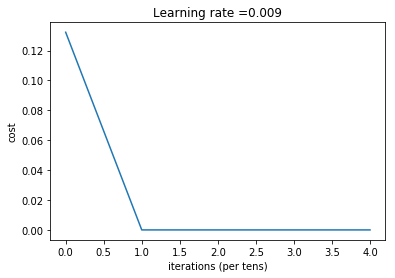

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 1.0


In [57]:
_, _, parameters = model(X_train, Y_train,train_age,train_sex, X_test, Y_test,val_age,val_sex)